In [1]:
import keras
import tensorflow as tf
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray
import numpy as np

2023-08-31 11:24:15.924981: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 11:24:16.008160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Set Keras backend for image data format

In [2]:
keras.backend.set_image_data_format('channels_first')

### Load ResNet50V2 model from Keras and freeze weights

In [3]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None
)

In [4]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, None, No  0           []                               
                                ne)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 3, None, Non  0           ['input_1[0][0]']                
                                e)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, None, No  9472        ['conv1_pad[0][0]']              
                                ne)                                                      

In [5]:
base_model.trainable = False

In [6]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, None, No  0           []                               
                                ne)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 3, None, Non  0           ['input_1[0][0]']                
                                e)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, None, No  9472        ['conv1_pad[0][0]']              
                                ne)                                                      

### Load data and set model parameters

In [7]:
nclasses = 33 #Number of classes in training data

In [8]:
import glob

from rioxarray.exceptions import NoDataInBounds
from sklearn.preprocessing import LabelEncoder 

In [9]:
# Data Loader from IDTreeS Dataset
rgb_paths = glob.glob('./train/RemoteSensing/RGB/*.tif')
bboxes_paths = glob.glob('./train/ITC/train_*.shp')
classes_path = './train/Field/train_data.csv'

class IDTreeSDataset:
    
    def __init__(self, rgb_paths, bboxes_paths, classes_path):
        self.rgb_paths = rgb_paths
        self.bboxes_paths = bboxes_paths
        self.classes_path = classes_path
        
    def generate_cutouts(self):
        # load bboxes
        bboxes = pd.concat([
            geopandas.read_file(p)
            for p in self.bboxes_paths
        ])
        
        # load classes 
        classes = pd.read_csv(self.classes_path)
        classes = classes.set_index('indvdID')

        # convert classes to categorical values
        le = LabelEncoder()
        le.fit(classes.taxonID)
        classes['categorical_label'] = le.transform(classes.taxonID)

        # load rgb data and make cutouts
        for rgb_path in self.rgb_paths:
            rgb = rioxarray.open_rasterio(rgb_path, masked=True)
            
            assert bboxes.crs == rgb.rio.crs

            # select relevant bboxes
            xmin, ymin, xmax, ymax = rgb.rio.bounds()
            bboxes_clip = bboxes.cx[xmin:xmax, ymin:ymax]
            bboxes_clip = bboxes_clip[~bboxes_clip.is_empty]
            
            for _, bbox in bboxes_clip.iterrows():
                
                indvdID = bbox['indvdID']

                if indvdID not in classes.index:
                    # issue: for some IDs, the class is not specified
                    continue
                
                label = classes.loc[indvdID]['categorical_label']
                if not isinstance(label, (int, np.integer)):
                    # print (indvdID, label)
                    # issue: there are multiple entries for the same ID
                    continue
                
                try:
                    cutout = rgb.rio.clip([bbox.geometry], drop=True)
                    data, flag = _image_preprocessor(cutout.data)
                    if flag:
                        # If image is too small or too large
                        continue
                except NoDataInBounds:
                    # issue: some polygons have very small intersections with the images
                    continue
                yield data, label
    
def _image_preprocessor(data):
    if (_remove_large_image(data) or _remove_small_images(data)):
        return data, True
    data = _image_padding(data)
    return data, False

def _remove_large_image(data):
    if max(data.shape[1:]) > 100:
        return True
    return False

def _remove_small_images(data):
    if min(data.shape[1:]) <= 32:
        return True
    return False

def _image_padding(data):
    #Pad each image 
    pad_width_x1 = np.floor((100 - data.shape[1])/2).astype(int)
    pad_width_x2 = 100 - data.shape[1] - pad_width_x1 
    pad_width_y1 = np.floor((100 - data.shape[2])/2).astype(int)
    pad_width_y2 = 100 - data.shape[2] - pad_width_y1
    data = np.pad(data, pad_width=[(0, 0),(pad_width_x1, pad_width_x2),(pad_width_y1, pad_width_y2)], mode='constant')
    return data

# Convert generator dataset in to suitable input for keras
ds = IDTreeSDataset(rgb_paths, bboxes_paths, classes_path)

Y = []
X = []
for arr, l in ds.generate_cutouts():
    Y.append(l) 
    X.append(arr)
Xc = np.stack(X)
Yc = np.asarray(Y)

# To use if data is to be generated directly during training
# ds = tf.data.Dataset.from_generator(
#     ds.generate_cutouts,
#     output_signature=(
#         tf.TensorSpec(shape=(3, 100, 100), dtype=tf.float32),
#         tf.TensorSpec(shape=(), dtype=tf.int64)
#     )
# ).batch(32)

In [10]:
def preprocess_data(X, Y, nclasses):
    X_p = keras.applications.resnet_v2.preprocess_input(X)
    Y_p = keras.utils.to_categorical(Y, nclasses)
    return X_p, Y_p

X, Y = preprocess_data(Xc, Yc, nclasses)

In [11]:
# Split train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0, shuffle=True)

### Create new model using the base model plus additional layers

In [12]:
def create_model():
    # Inputs
    inputs = keras.Input(shape=(3, 100, 100))

    # Run input image through our base model (ResNet)
    x = base_model(inputs, training = False)

    # Convert features from base model to a vector
    x = keras.layers.GlobalAveragePooling2D()(x)

    # # Create additional dense layers to fine tune the model
    # x = keras.layers.Dense(256)(x)
    # x = keras.layers.Dense(64)(x)

    # Create output layer
    outputs = keras.layers.Dense(nclasses, activation="softmax")(x)

    return keras.Model(inputs, outputs)

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048, None, None)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 33)                67617     
                                                                 
Total params: 23,632,417
Trainable params: 67,617
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [14]:
# # Train the model with generator
# epochcounter = 1
# while epochcounter <= 50:
#     model.fit(ds, steps_per_epoch=17)
#     epochcounter += 1

# Train the model with preprocessed data
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
16/16 [==============================] - 34s 2s/step - loss: 2.9579 - accuracy: 0.1426 - val_loss: 2.5397 - val_accuracy: 0.2037
Epoch 2/50
16/16 [==============================] - 33s 2s/step - loss: 2.2955 - accuracy: 0.2789 - val_loss: 2.4340 - val_accuracy: 0.2222
Epoch 3/50
16/16 [==============================] - 36s 2s/step - loss: 2.0873 - accuracy: 0.3388 - val_loss: 2.3439 - val_accuracy: 0.2222
Epoch 4/50
16/16 [==============================] - 39s 2s/step - loss: 1.9260 - accuracy: 0.3926 - val_loss: 2.3119 - val_accuracy: 0.2222
Epoch 5/50
16/16 [==============================] - 49s 3s/step - loss: 1.8110 - accuracy: 0.4174 - val_loss: 2.2364 - val_accuracy: 0.2963
Epoch 6/50
16/16 [==============================] - 47s 3s/step - loss: 1.7003 - accuracy: 0.4483 - val_loss: 2.2265 - val_accuracy: 0.2963
Epoch 7/50
16/16 [==============================] - 51s 3s/step - loss: 1.6314 - accuracy: 0.4752 - val_loss: 2.1953 - val_accuracy: 0.3148
Epoch 8/50
16/16 [==

In [15]:
# Predict on the train and test set
ypred_train = np.argmax(model.predict(X_train), axis=1)
ypred_val = np.argmax(model.predict(X_test), axis=1)

2/2 [==============================] - 3s 1s/step


In [20]:
import seaborn as sns
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

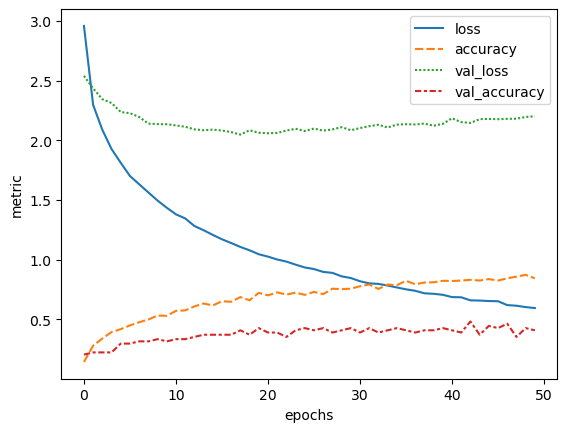

In [23]:
plot_history(history, ['loss', 'accuracy', 'val_loss', 'val_accuracy'] )

In [ ]:
# # If data was from a generator function, create output labels for comparison
# ylabels = []
# for element in ds:
#     ylabels = ylabels.extend(list(element[1].numpy()))
# ylabels = np.array(ylabels)

In [19]:
import random 
print ('Correct predictions, Total samples, Accuracy')
print (np.count_nonzero(ypred_train - np.argmax(y_train, axis=1) == 0), y_train.shape[0], np.count_nonzero(ypred_train - np.argmax(y_train, axis=1) == 0)/y_train.shape[0])
print (np.count_nonzero(ypred_val - np.argmax(y_test, axis=1) == 0), y_test.shape[0], np.count_nonzero(ypred_val - np.argmax(y_test, axis=1) == 0)/y_test.shape[0])

Correct predictions, Total samples, Accuracy
422 484 0.871900826446281
22 54 0.4074074074074074


In [33]:
np.unique(Yc, return_counts=True)   

(array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19,
        20, 21, 22, 24, 25, 26, 28, 29, 30, 31, 32]),
 array([  5,  92,   1,  26,   2,   1,   1,   1,  14,   7,   1,  25,   5,
          2,   4,  78,   4,   3,  73,  42,   5,   3,  17,   7,   1, 112,
          2,   4]))